In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is levearing a working model's exiting architecture and learned patterns for our own problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similiar to our own.
2. Can leverage a working neural network architectre which has alreday learned patterns on similar data to our own, then we can adapta those patterns to our own data.

## Downloading and becoming one with the data


In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-12-12 14:07:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.251.175.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.8MB/s    in 8.2s    

2024-12-12 14:07:13 (19.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Create data loader (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen = ImageDataGenerator(rescale= 1/255.)

print ("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print ("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callback (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be perfomed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.


In [ ]:
# Create TensorBoard callback (funtionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are goint to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsin the TensorFlow Hub page and sorting for image classification, we foud the following feature vector model:https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url_v1 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

efficientnet_url_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes = 10):
  """
  Take a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Arg:
    model_url (str): A TensoFlow Hub feature extraction URL.
    num_classes (int): Number of output neuros in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #freeze the alreday learned patterns
                                           name="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and teting ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Let's fit our Resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = EPOCHS,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                           experiment_name="resnet50v2")]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20241212-140730
Epoch 1/5
24/24 [==============================] - 22s 620ms/step - loss: 1.8829 - accuracy: 0.3707 - val_loss: 1.1887 - val_accuracy: 0.6272
Epoch 2/5
24/24 [==============================] - 10s 444ms/step - loss: 0.8671 - accuracy: 0.7547 - val_loss: 0.8239 - val_accuracy: 0.7512
Epoch 3/5
24/24 [==============================] - 11s 453ms/step - loss: 0.5994 - accuracy: 0.8293 - val_loss: 0.7387 - val_accuracy: 0.7732
Epoch 4/5
24/24 [==============================] - 11s 453ms/step - loss: 0.4657 - accuracy: 0.8813 - val_loss: 0.6951 - val_accuracy: 0.7828
Epoch 5/5
24/24 [==============================] - 11s 473ms/step - loss: 0.3706 - accuracy: 0.9147 - val_loss: 0.6691 - val_accuracy: 0.7880


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Arg:
    history: TensorFlow History object.

  Returns:
    Plots of training and validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

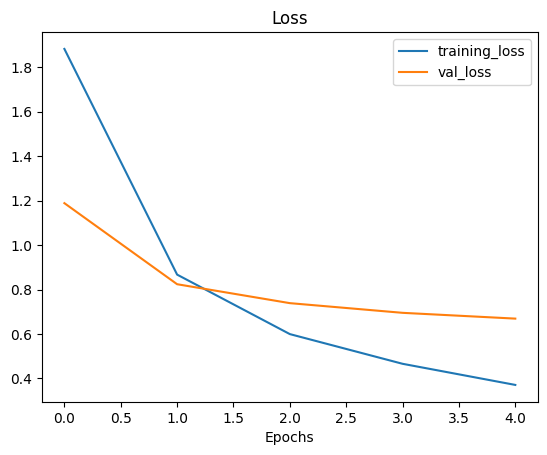

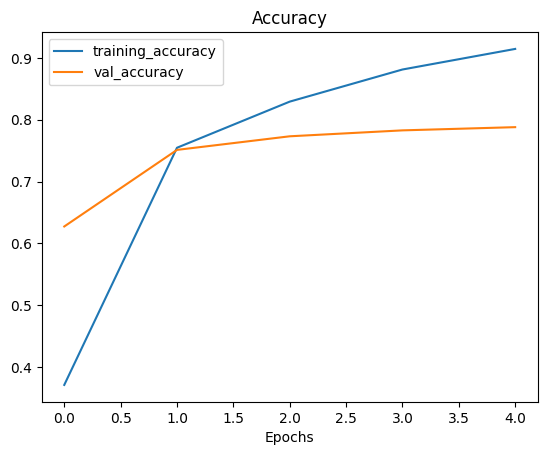

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetV0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create model
efficientnet_model_v1 = create_model(model_url=efficientnet_url_v1, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model_v1.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history_v1 = efficientnet_model_v1.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20241212-145945
Epoch 1/5
24/24 [==============================] - 21s 492ms/step - loss: 1.8399 - accuracy: 0.4440 - val_loss: 1.2880 - val_accuracy: 0.7372
Epoch 2/5
24/24 [==============================] - 11s 480ms/step - loss: 1.0593 - accuracy: 0.7693 - val_loss: 0.8587 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 10s 434ms/step - loss: 0.7535 - accuracy: 0.8373 - val_loss: 0.6898 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 11s 473ms/step - loss: 0.6061 - accuracy: 0.8653 - val_loss: 0.6029 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 11s 460ms/step - loss: 0.5108 - accuracy: 0.8867 - val_loss: 0.5499 - val_accuracy: 0.8660


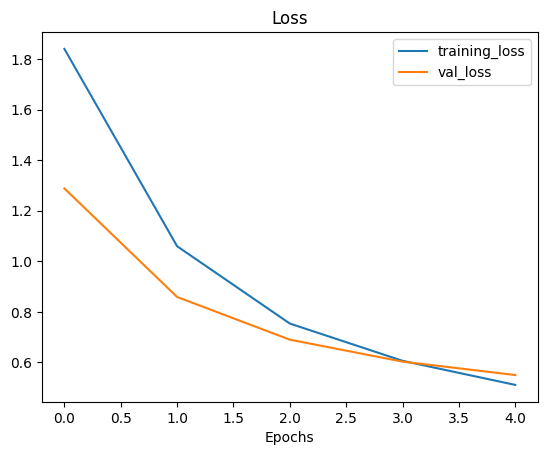

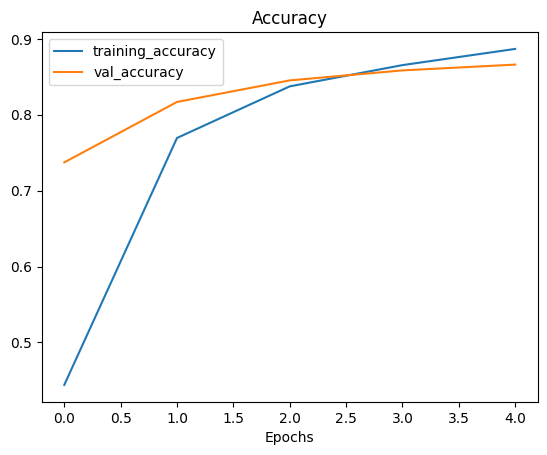

In [ ]:
plot_loss_curves(efficientnet_history_v1)

In [ ]:
# Create model
efficientnet_model_v2 = create_model(model_url=efficientnet_url_v2, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model_v2.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history_v2 = efficientnet_model_v2.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0_v2")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0_v2/20241212-150105
Epoch 1/5
24/24 [==============================] - 19s 489ms/step - loss: 1.9383 - accuracy: 0.3760 - val_loss: 1.5092 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 10s 434ms/step - loss: 1.2790 - accuracy: 0.6840 - val_loss: 1.1294 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 10s 413ms/step - loss: 0.9885 - accuracy: 0.7653 - val_loss: 0.9568 - val_accuracy: 0.7384
Epoch 4/5
24/24 [==============================] - 9s 395ms/step - loss: 0.8312 - accuracy: 0.7987 - val_loss: 0.8624 - val_accuracy: 0.7556
Epoch 5/5
24/24 [==============================] - 11s 451ms/step - loss: 0.7229 - accuracy: 0.8253 - val_loss: 0.8036 - val_accuracy: 0.7724


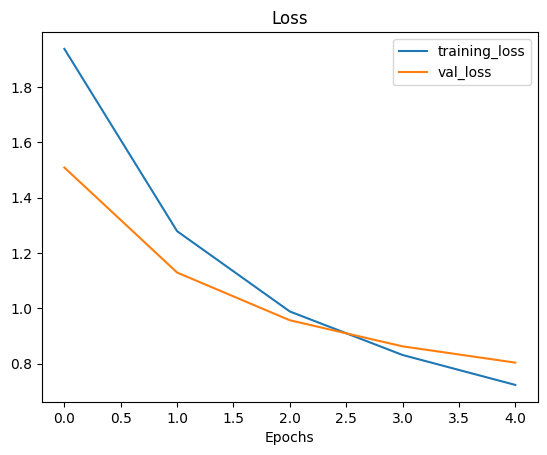

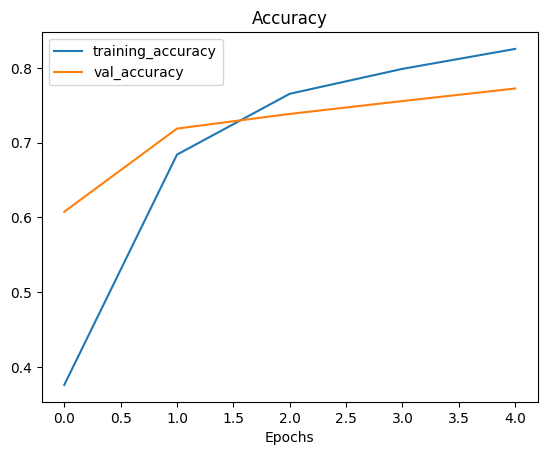

In [ ]:
plot_loss_curves(efficientnet_history_v2)

In [ ]:
efficientnet_model_v1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficientnet_model_v2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# How many layers does our efficientnet feature extractor have?
len(efficientnet_model_v1.layers[0].weights), len(efficientnet_model_v2.layers[0].weights)


(309, 359)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsover (e.g. using *ImageNet* model on 1000 ImageNet classes, none of your own)


* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. *EfficientNetB0* trained on ImageNet) and adjust the output layer for your own problem (e.g 1000classes -> 10 classes of food).

Here all of the layer generally stay frozen except for the output layer.

* **"Fine-tuning" transfer learning** - use the prelearned patterns of and existing model and "fine-tune" many or all of the underlying layers (including new output layers).

Here we might unfreeze some or all of the layers in the underlying model, and the data set might change. We can update the parameters with our own custom dataset.



## Comparing our model's results using TensorBoard

> 🔑**Note:** When you upload things to TensorBoard.dev you experiments are public. So if you're runing private experiments (things you don't want other to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientnetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

2024-12-12 15:52:59.204606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 15:52:59.204663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 15:52:59.205993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 15:53:00.275837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb